In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lora_modem import LoraModulator, LoraDemodulator, LoraReservedArtifacts
import adi

In [2]:
class LoraSync:
    def __init__(self, spreading_factor, samples_per_chip, demodulator, preamble_number):
        self._spreading_factor = spreading_factor
        self._samples_per_chip = samples_per_chip
        self._demodulator = demodulator 
        self._preamble_number = preamble_number

    def _detect_chirp(self, signal_segment, chirp_type):
        """Helper function to detect specific chirp types in a given signal segment."""
        chirp_type = 'upchirp' if chirp_type == 'downchirp' else 'downchirp'
        return self._demodulator.demodulate_symbol(signal_segment, chirp_type) == 0

    def _get_samples_per_symbol(self):
        return self._samples_per_chip * 2 ** self._spreading_factor

    def phase1sync(self, rx_signal):
        sps = self._get_samples_per_symbol()
        
        for i in range(len(rx_signal)):
            # Extract the segment to analyze
            segment = rx_signal[i:i + sps]
            if len(segment) < sps:
                break
            # Check if the segment is an upchirp´
            if self._detect_chirp(segment, 'upchirp'):
                print('Upchirp detected at index: ', i)
                preamble_found, payload_index, reconstructed_preamble = self.phase2sync(rx_signal, i)
                if preamble_found:
                    print('Synchronization successful!')
                    package_length = self._demodulator.demodulate_symbol(rx_signal[payload_index:payload_index + sps], 'downchirp')
                    print('Package length: ', package_length)
                    if self._samples_per_chip>1:
                        print("(not) Refining synchronization... (SPC > 1 requires phase 3 synchronization, NOT IMPLEMENTED)")
                    return True, payload_index, package_length
        return False, -1, -1
    
    def phase2sync(self, rx_signal, candidate_index):
        sps = self._get_samples_per_symbol()
        
        current_index = candidate_index + sps
        
        reconstructed_preamble = []
        while True:
            segment = rx_signal[current_index:current_index + sps]
            if len(segment) < sps:
                break
            if self._detect_chirp(segment, 'upchirp'):
                reconstructed_preamble.append(LoraReservedArtifacts.FULL_UPCHIRP)
                current_index += sps
                continue
            elif self._detect_chirp(segment, 'downchirp'):
                reconstructed_preamble.append(LoraReservedArtifacts.FULL_DOWNCHIRP)
                current_index += sps
                alleged_second_downchip = rx_signal[current_index:current_index + sps]
                if self._detect_chirp(alleged_second_downchip, 'downchirp'):
                    reconstructed_preamble.append(LoraReservedArtifacts.FULL_DOWNCHIRP)
                    payload_index = int(current_index + sps * 1.25)
                    print('Payload index: ', payload_index)
                    upchirps = reconstructed_preamble.count(LoraReservedArtifacts.FULL_UPCHIRP)
                    downchirps = reconstructed_preamble.count(LoraReservedArtifacts.FULL_DOWNCHIRP)
                    print(f'Reconstructed preamble: [{upchirps + 1} upchirps, {downchirps} downchirps]')
                    return True, payload_index, reconstructed_preamble
                else:
                    break
            else:
                break
        return False, -1, -1

In [3]:
#------------------------------- SDR Parameter Configuration -------------------------------

Uri              = "ip:192.168.1.35" # RELLENAR CON LA IP DEL SDR ASIGNADO
SamplingRate     = 2e6           # Sample rate RX and TX paths[Samples/Sec]
Loopback         = 1             # 0=Disabled, 1=Digital, 2=RF

TxLOFreq         = 942e6         # Carrier frequency of TX path [Hz] RELLENAR CON LA FREC. DE PORTADORA ASIGNADA
TxAtten          = -10           # Attenuation applied to TX path, valid range is -90 to 0 dB [dB]
TxRfBw           = 4e6           # Bandwidth of front-end analog filter of TX path [Hz]

RxLOFreq         = TxLOFreq      # Carrier frequency of RX path [Hz]
GainControlModes = "slow_attack" # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain   = 0             # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'    
RxRfBw           = TxRfBw        # Bandwidth of front-end analog filter of RX path [Hz] 
RxBufferSize     = 2**20-1

In [4]:
#------------------------------- SDR Setup ------------------------------- 

sdr             = adi.Pluto(Uri)
sdr.sample_rate = SamplingRate
sdr.loopback    = Loopback
#Tx:
sdr.tx_lo                 = int(TxLOFreq)
sdr.tx_hardwaregain_chan0 = TxAtten 
sdr.tx_rf_bandwidth       = int(TxRfBw)
sdr.tx_cyclic_buffer      = True
# Rx:
sdr.rx_lo                   = int(RxLOFreq)
sdr.gain_control_mode_chan0 = GainControlModes
sdr.rx_rf_bandwidth         = int(RxRfBw)
sdr.rx_cyclic_buffer        = False
sdr.rx_buffer_size          = RxBufferSize

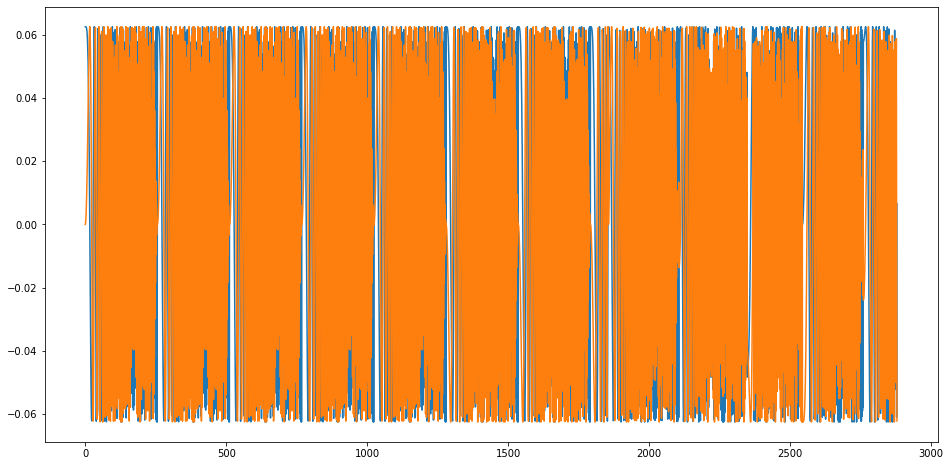

2880


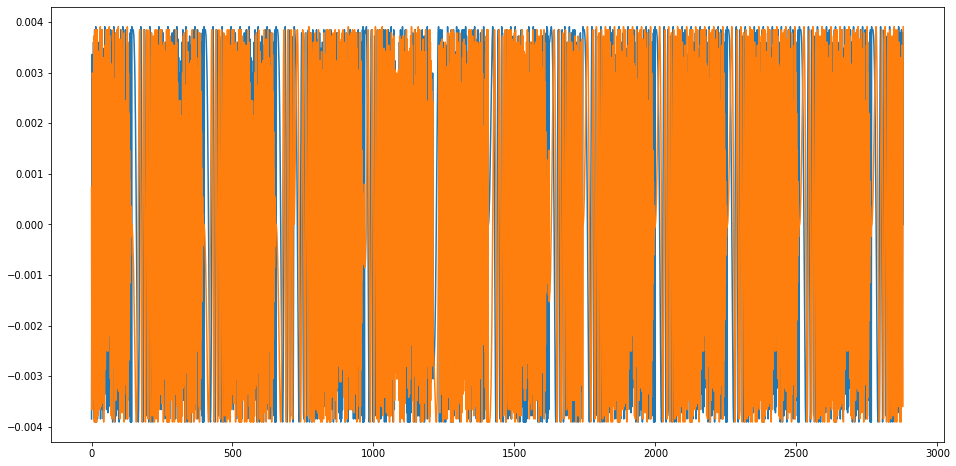

Upchirp detected at index:  475
Upchirp detected at index:  478
Upchirp detected at index:  499
Upchirp detected at index:  713
Upchirp detected at index:  714
Upchirp detected at index:  953
Upchirp detected at index:  956
Upchirp detected at index:  957
Upchirp detected at index:  1149
Upchirp detected at index:  1152
Upchirp detected at index:  1367
Upchirp detected at index:  1624
Upchirp detected at index:  1742
Payload index:  3598
Reconstructed preamble: [5 upchirps, 2 downchirps]
Synchronization successful!
Package length:  2
(not) Refining synchronization... (SPC > 1 requires phase 3 synchronization, NOT IMPLEMENTED)
Payload detected!
Received symbols:  [2, 9, 39]


In [5]:
# ----- Playground -----
spreading_factor = 7
bandwidth = 125e3
samples_per_chip = 2
preamble_number = 3

modulator = LoraModulator(spreading_factor, bandwidth, samples_per_chip)
demodulator = LoraDemodulator(spreading_factor, bandwidth, samples_per_chip)
synchronizer = LoraSync(spreading_factor, samples_per_chip, demodulator, preamble_number)
payload = [10, 40, 60]
timeline, frequency, signal = modulator.modulate_implicit_package(preamble_number, payload)
signal = np.array(signal)
plt.figure(figsize=(16,8))
plt.plot(np.real(signal))
plt.plot(np.imag(signal))
plt.show()

print(len(signal))
sdr.tx(signal * 2**14)
received_signal = sdr.rx() / 2**14
# received_signal = np.roll(signal, -100)
plt.figure(figsize=(16,8))
plt.plot(np.real(received_signal[:len(signal)]))
plt.plot(np.imag(received_signal[:len(signal)]))
plt.show()

preamble_found, payload_index, package_length = synchronizer.phase1sync(received_signal)

if preamble_found:
    print('Payload detected!')
    message_samples = (package_length + 1) * (2**spreading_factor * samples_per_chip) 
    received_symbols = demodulator.demodulate_symbols(received_signal[payload_index : payload_index + message_samples])
    print('Received symbols: ', received_symbols)


In [6]:
# Since it is not possible to turn off Tx, it is configured to transmit at low power and on a different frequency than Rx.
sdr.tx_destroy_buffer()
sdr.tx_hardwaregain_chan0 = -89 
sdr.tx_lo                 = int(2400e6)
sdr.rx_lo                 = int(950e6)
sdr.tx(np.zeros(2048))
# Destroy radio object
del(sdr)